In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for Precision WorkStation


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

In [4]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [5]:
win_id = 5

In [6]:
# stacks = ['MD661', 'MD662']
# stacks = ['MD661', 'ChatCryoJane201710']
# stacks = ['MD589', 'MD594']
stacks = ['MD589', 'MD661']

In [7]:
windowing_properties = windowing_settings[win_id]
patch_size = windowing_properties['patch_size']
half_size = patch_size/2
spacing = windowing_properties['spacing']

sample_locations_allStacks = {}
for stack in stacks:
    w, h = metadata_cache['image_shape'][stack]
    sample_locations_allStacks[stack] = grid_parameters_to_sample_locations(grid_spec=(patch_size, spacing, w, h))

In [7]:
# addresses_df = DataFrame([(stack, sec, grid_idx) 
#            for stack in ['MD661', 'MD662'] 
#            for sec in np.arange(metadata_cache['section_limits'][stack][0], 
#                                 metadata_cache['section_limits'][stack][-1]+1)
#            for grid_idx in range(len(sample_locations_allStacks[stack]))], 
#           columns=['stack', 'section', 'grid_idx'])

In [8]:
# location_column = [sample_locations_allStacks[addr['stack']][addr['grid_idx']]
# for i, addr in addresses_df.iterrows()]

# addresses_df = addresses_df.assign(location=location_column)

In [8]:
grid_indices_lookup_allStacks = {}
for stack in stacks:
    try:
        grid_indices_lookup_allStacks[stack] = \
        DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                           by_human=True, timestamp='latest')
    except:
        sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD661" "/home/yuncong/CSHL_labelings_v3/MD661" --exclude "*" --include "*contours*"
latest timestamp:  08022017175151


In [9]:
from itertools import chain
all_labels = sorted(list(set(chain.from_iterable(set(grid_indices_lookup_allStacks[st].columns.tolist()) for st in stacks))))

In [10]:
address_multidx = pd.MultiIndex.from_tuples([(stack, sec, grid_idx) 
           for stack in sorted(stacks)
           for sec in np.arange(metadata_cache['section_limits'][stack][0], 
                                metadata_cache['section_limits'][stack][-1]+1)
           for grid_idx in range(len(sample_locations_allStacks[stack]))], 
          names=['stack', 'section', 'grid_idx'])

In [11]:
address_label_df_allStacks = DataFrame(columns=all_labels,
    index=address_multidx, data=False)

In [12]:
surround_margins = [200, 500]

In [ ]:
# stack = 'MD661'
for stack in stacks:
# for stack in ['MD661']:
# for stack in ['ChatCryoJane201710']:

    prep_id = 2

    contours_df = DataManager.load_annotation_v4(stack=stack, by_human=True, suffix='contours', timestamp='latest')
    contours = contours_df[(contours_df['orientation'] == 'sagittal') & (contours_df['downsample'] == 1)]
    contours = contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'downsample', 'creator'])

    contours_df = convert_annotation_v3_original_to_aligned_cropped(contours, stack=stack)
    download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, prep_id=prep_id), is_dir=True)

    contours_grouped = contours_df.groupby('section')
    
    ##########################################
    
    for sec, cnt_group in contours_grouped:
        sys.stderr.write('Computing class label to grid indices lookup-table for section %d...\n' % sec)
        if is_invalid(sec=sec, stack=stack):
            continue
        polygons_this_sec = [(contour['name'], contour['vertices']) for contour_id, contour in cnt_group.iterrows()]
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec, prep_id=prep_id)

        t = time.time()
        label_to_grid_indices_map = locate_patches_v2(grid_spec=win_id_to_gridspec(win_id=5, stack=stack), 
                                                      mask_tb=mask_tb, polygons=polygons_this_sec, \
                                                      surround_margins=surround_margins)
        sys.stderr.write("Identify in-polygon grid indices: %.2f s\n" % (time.time()-t))

        for label, grid_indices in label_to_grid_indices_map.iteritems():
            if label == 'bg' or label == 'noclass' or 'negative' in label: # Ignore bg, noclass, x_negative
                continue
            sys.stderr.write("%s, sec %d: %d patches from label %s.\n" % (stack, sec, len(grid_indices), label))
#             t = time.time()
            for grid_idx in grid_indices:
                address_label_df_allStacks.loc[(stack, sec, grid_idx), label] = True
#             sys.stderr.write("%.2f s\n" % (time.time()-t))

    del contours_df, contours_grouped, contours

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807


Computing class label to grid indices lookup-table for section 92...
Identify in-polygon grid indices: 0.54 s
MD589, sec 92: 7172 patches from label Cb.
MD589, sec 92: 1384 patches from label Cb_surround_200_noclass.
MD589, sec 92: 2674 patches from label Cb_surround_500_noclass.
Computing class label to grid indices lookup-table for section 94...
Identify in-polygon grid indices: 0.17 s
MD589, sec 94: 23 patches from label VCA.
MD589, sec 94: 123 patches from label VCA_surround_200_noclass.
MD589, sec 94: 432 patches from label VCA_surround_500_noclass.
Computing class label to grid indices lookup-table for section 95...
Identify in-polygon grid indices: 0.18 s
MD589, sec 95: 43 patches from label VCA.
MD589, sec 95: 180 patches from label VCA_surround_200_noclass.
MD589, sec 95: 580 patches from label VCA_surround_500_noclass.
Computing class label to grid indices lookup-table for section 96...
Identify in-polygon grid indices: 0.19 s
MD589, sec 96: 69 patches from label VCA.
MD589, 

MD589, sec 107: 538 patches from label VCA.
MD589, sec 107: 508 patches from label VCA_surround_200_noclass.
MD589, sec 107: 1276 patches from label VCA_surround_500_noclass.
MD589, sec 107: 64 patches from label VCP_surround_200_VCA.
MD589, sec 107: 190 patches from label VCP.
MD589, sec 107: 49 patches from label VCP_surround_200_DC.
MD589, sec 107: 258 patches from label DC_surround_500_VCA.
MD589, sec 107: 545 patches from label DC_surround_200_noclass.
MD589, sec 107: 178 patches from label DC_surround_500_VCP.
MD589, sec 107: 238 patches from label VCA_surround_500_DC.
MD589, sec 107: 252 patches from label VCP_surround_500_DC.
Computing class label to grid indices lookup-table for section 108...
Identify in-polygon grid indices: 1.06 s
MD589, sec 108: 232 patches from label VCA_surround_500_VCP.
MD589, sec 108: 328 patches from label DC.
MD589, sec 108: 63 patches from label VCA_surround_200_VCP.
MD589, sec 108: 291 patches from label VCP_surround_500_VCA.
MD589, sec 108: 55 pat

MD589, sec 113: 35 patches from label DC_surround_200_VCA.
MD589, sec 113: 32 patches from label VCA_surround_200_DC.
MD589, sec 113: 572 patches from label VCP_surround_200_noclass.
MD589, sec 113: 1300 patches from label VCP_surround_500_noclass.
MD589, sec 113: 31 patches from label DC_surround_200_VCP.
MD589, sec 113: 1759 patches from label DC_surround_500_noclass.
MD589, sec 113: 279 patches from label VCA.
MD589, sec 113: 521 patches from label VCA_surround_200_noclass.
MD589, sec 113: 1459 patches from label VCA_surround_500_noclass.
MD589, sec 113: 32 patches from label VCP_surround_200_VCA.
MD589, sec 113: 372 patches from label VCP.
MD589, sec 113: 40 patches from label VCP_surround_200_DC.
MD589, sec 113: 187 patches from label DC_surround_500_VCA.
MD589, sec 113: 593 patches from label DC_surround_200_noclass.
MD589, sec 113: 240 patches from label DC_surround_500_VCP.
MD589, sec 113: 205 patches from label VCA_surround_500_DC.
MD589, sec 113: 296 patches from label VCP_su

Computing class label to grid indices lookup-table for section 120...
Identify in-polygon grid indices: 1.14 s
MD589, sec 120: 119 patches from label VCA_surround_500_VCP.
MD589, sec 120: 174 patches from label DC.
MD589, sec 120: 33 patches from label VCA_surround_200_VCP.
MD589, sec 120: 59 patches from label VCP_surround_500_VCA.
MD589, sec 120: 485 patches from label VCP_surround_200_noclass.
MD589, sec 120: 1625 patches from label VCP_surround_500_noclass.
MD589, sec 120: 861 patches from label PBG_surround_500_noclass.
MD589, sec 120: 38 patches from label DC_surround_200_VCP.
MD589, sec 120: 1750 patches from label DC_surround_500_noclass.
MD589, sec 120: 83 patches from label VCA.
MD589, sec 120: 445 patches from label VCA_surround_200_noclass.
MD589, sec 120: 158 patches from label Sp5I.
MD589, sec 120: 1561 patches from label VCA_surround_500_noclass.
MD589, sec 120: 14 patches from label VCP_surround_200_VCA.
MD589, sec 120: 143 patches from label VCP.
MD589, sec 120: 1 patc

MD589, sec 126: 1261 patches from label Sp5O_surround_500_noclass.
MD589, sec 126: 442 patches from label DC_surround_200_noclass.
MD589, sec 126: 1327 patches from label Sp5I_surround_500_noclass.
Computing class label to grid indices lookup-table for section 127...
Identify in-polygon grid indices: 0.85 s
MD589, sec 127: 95 patches from label DC.
MD589, sec 127: 168 patches from label Sp5I_surround_500_Sp5O.
MD589, sec 127: 1123 patches from label PBG_surround_500_noclass.
MD589, sec 127: 1586 patches from label DC_surround_500_noclass.
MD589, sec 127: 168 patches from label Sp5O.
MD589, sec 127: 304 patches from label Sp5I.
MD589, sec 127: 378 patches from label Sp5O_surround_200_noclass.
MD589, sec 127: 15 patches from label PBG.
MD589, sec 127: 249 patches from label PBG_surround_200_noclass.
MD589, sec 127: 111 patches from label Sp5O_surround_200_Sp5I.
MD589, sec 127: 105 patches from label Sp5I_surround_200_Sp5O.
MD589, sec 127: 501 patches from label Sp5I_surround_200_noclass.

MD589, sec 131: 5 patches from label Sp5O_surround_500_Sp5C.
MD589, sec 131: 192 patches from label SNR.
MD589, sec 131: 210 patches from label PBG_surround_500_VLL.
MD589, sec 131: 364 patches from label DC_surround_200_noclass.
MD589, sec 131: 398 patches from label Sp5O_surround_500_Sp5I.
MD589, sec 131: 471 patches from label Sp5I_surround_200_noclass.
MD589, sec 131: 4 patches from label PBG_surround_200_VLL.
MD589, sec 131: 1310 patches from label Sp5I_surround_500_noclass.
Computing class label to grid indices lookup-table for section 132...
Identify in-polygon grid indices: 1.83 s
MD589, sec 132: 134 patches from label Sp5C_surround_200_Sp5I.
MD589, sec 132: 30 patches from label VLL_surround_500_SNR.
MD589, sec 132: 247 patches from label PBG_surround_200_noclass.
MD589, sec 132: 56 patches from label DC.
MD589, sec 132: 341 patches from label Sp5C_surround_200_noclass.
MD589, sec 132: 18 patches from label SNR_surround_500_PBG.
MD589, sec 132: 160 patches from label Sp5I_surr

MD589, sec 135: 12 patches from label SNR_surround_500_PBG.
MD589, sec 135: 2030 patches from label VLL_surround_500_noclass.
MD589, sec 135: 261 patches from label Sp5I_surround_500_Sp5C.
MD589, sec 135: 733 patches from label VLL_surround_200_noclass.
MD589, sec 135: 362 patches from label Sp5I_surround_500_Sp5O.
MD589, sec 135: 8 patches from label PBG_surround_200_SNR.
MD589, sec 135: 728 patches from label SNR_surround_200_noclass.
MD589, sec 135: 555 patches from label Pr5VL.
MD589, sec 135: 417 patches from label VLL.
MD589, sec 135: 2036 patches from label SC_surround_500_noclass.
MD589, sec 135: 8 patches from label SNR_surround_200_PBG.
MD589, sec 135: 481 patches from label Sp5O_surround_500_Sp5I.
MD589, sec 135: 811 patches from label PBG_surround_500_noclass.
MD589, sec 135: 452 patches from label Sp5C_surround_500_Sp5I.
MD589, sec 135: 468 patches from label Pr5DM.
MD589, sec 135: 192 patches from label Sp5O_surround_500_Pr5VL.
MD589, sec 135: 1362 patches from label DC_s

MD589, sec 138: 467 patches from label Sp5C_surround_500_Sp5I.
MD589, sec 138: 1269 patches from label DC_surround_500_noclass.
MD589, sec 138: 947 patches from label Sp5O.
MD589, sec 138: 837 patches from label Sp5I.
MD589, sec 138: 775 patches from label Sp5O_surround_200_noclass.
MD589, sec 138: 430 patches from label Sp5C.
MD589, sec 138: 1019 patches from label Sp5C_surround_500_noclass.
MD589, sec 138: 837 patches from label Sp5O_surround_500_Sp5I.
MD589, sec 138: 187 patches from label SNR_surround_500_VLL.
MD589, sec 138: 1979 patches from label VLL_surround_500_noclass.
MD589, sec 138: 645 patches from label Sp5O_surround_200_Sp5I.
MD589, sec 138: 583 patches from label Sp5I_surround_200_Sp5O.
MD589, sec 138: 612 patches from label SC_surround_200_noclass.
MD589, sec 138: 136 patches from label Sp5I_surround_200_Sp5C.
MD589, sec 138: 2189 patches from label Sp5O_surround_500_noclass.
MD589, sec 138: 56 patches from label Sp5C_surround_500_Sp5O.
MD589, sec 138: 406 patches from

MD589, sec 141: 1070 patches from label Sp5O_surround_500_Sp5I.
MD589, sec 141: 4 patches from label X_surround_200_Sp5O.
MD589, sec 141: 1803 patches from label SC_surround_500_noclass.
MD589, sec 141: 2904 patches from label IC_surround_500_noclass.
MD589, sec 141: 1151 patches from label X_surround_500_noclass.
MD589, sec 141: 372 patches from label X_surround_200_noclass.
MD589, sec 141: 1079 patches from label IC_surround_200_noclass.
MD589, sec 141: 173 patches from label X_surround_500_Sp5I.
MD589, sec 141: 1149 patches from label DC_surround_500_noclass.
MD589, sec 141: 960 patches from label Sp5O.
MD589, sec 141: 14 patches from label X_surround_500_DC.
MD589, sec 141: 1178 patches from label Sp5I.
MD589, sec 141: 785 patches from label Sp5O_surround_200_noclass.
MD589, sec 141: 171 patches from label VLL_surround_500_SNR.
MD589, sec 141: 595 patches from label Sp5C.
MD589, sec 141: 36 patches from label Sp5O_surround_500_X.
MD589, sec 141: 461 patches from label SC.
MD589, se

MD589, sec 144: 497 patches from label VLL_surround_200_noclass.
MD589, sec 144: 479 patches from label Sp5I_surround_500_Sp5O.
MD589, sec 144: 149 patches from label SC_surround_200_IC.
MD589, sec 144: 31 patches from label DC_surround_500_X.
MD589, sec 144: 814 patches from label SNR_surround_200_noclass.
MD589, sec 144: 184 patches from label VLL.
MD589, sec 144: 330 patches from label X_surround_200_noclass.
MD589, sec 144: 2247 patches from label SC_surround_500_noclass.
MD589, sec 144: 2463 patches from label IC_surround_500_noclass.
MD589, sec 144: 1100 patches from label X_surround_500_noclass.
MD589, sec 144: 913 patches from label IC_surround_200_noclass.
MD589, sec 144: 664 patches from label Sp5C_surround_200_noclass.
MD589, sec 144: 415 patches from label Sp5C_surround_500_Sp5I.
MD589, sec 144: 1073 patches from label DC_surround_500_noclass.
MD589, sec 144: 597 patches from label Sp5O.
MD589, sec 144: 9 patches from label X_surround_500_DC.
MD589, sec 144: 1553 patches fr

Identify in-polygon grid indices: 3.13 s
MD589, sec 146: 123 patches from label SNC_surround_200_SNR.
MD589, sec 146: 191 patches from label VLL_surround_500_SNR.
MD589, sec 146: 604 patches from label SuVe_surround_200_noclass.
MD589, sec 146: 5 patches from label DC.
MD589, sec 146: 807 patches from label Sp5C_surround_200_noclass.
MD589, sec 146: 8 patches from label SNR_surround_500_SNC.
MD589, sec 146: 583 patches from label SC_surround_500_IC.
MD589, sec 146: 900 patches from label SNC_surround_500_noclass.
MD589, sec 146: 469 patches from label VLL_surround_200_noclass.
MD589, sec 146: 73 patches from label SuVe_surround_500_8n.
MD589, sec 146: 159 patches from label SC_surround_200_IC.
MD589, sec 146: 44 patches from label X_surround_500_8n.
MD589, sec 146: 2392 patches from label SNR_surround_500_noclass.
MD589, sec 146: 33 patches from label DC_surround_500_X.
MD589, sec 146: 826 patches from label SNR_surround_200_noclass.
MD589, sec 146: 13 patches from label DC_surround_50

MD589, sec 148: 961 patches from label SNC_surround_500_noclass.
MD589, sec 148: 130 patches from label SNR_surround_500_VLL.
MD589, sec 148: 848 patches from label SC_surround_200_noclass.
MD589, sec 148: 245 patches from label SNC_surround_200_noclass.
MD589, sec 148: 31 patches from label X.
MD589, sec 148: 1249 patches from label IC.
MD589, sec 148: 3 patches from label DC_surround_500_8n.
MD589, sec 148: 2 patches from label SuVe_surround_500_DC.
MD589, sec 148: 11 patches from label SuVe_surround_200_8n.
MD589, sec 148: 526 patches from label IC_surround_500_SC.
MD589, sec 148: 12 patches from label SNC.
MD589, sec 148: 13 patches from label 8n_surround_500_X.
MD589, sec 148: 17 patches from label 8n_surround_200_SuVe.
MD589, sec 148: 960 patches from label 7n_surround_500_noclass.
MD589, sec 148: 2 patches from label X_surround_500_DC.
MD589, sec 148: 2 patches from label 8n_surround_500_DC.
MD589, sec 148: 484 patches from label SNR.
MD589, sec 148: 255 patches from label DC_su

MD589, sec 150: 18 patches from label Cb_surround_200_LVe.
MD589, sec 150: 2346 patches from label SNR_surround_500_noclass.
MD589, sec 150: 2 patches from label LVe_surround_500_DC.
MD589, sec 150: 5 patches from label 8n_surround_500_X.
MD589, sec 150: 4886 patches from label Cb.
MD589, sec 150: 247 patches from label DC_surround_200_noclass.
MD589, sec 150: 1295 patches from label SC.
MD589, sec 150: 341 patches from label 8n_surround_200_noclass.
MD589, sec 150: 1569 patches from label 5N_surround_500_noclass.
MD589, sec 150: 958 patches from label IC_surround_500_Cb.
MD589, sec 150: 1221 patches from label 5TT_surround_500_noclass.
MD589, sec 150: 49 patches from label 7n.
MD589, sec 150: 2 patches from label DC.
MD589, sec 150: 861 patches from label Sp5C_surround_200_noclass.
MD589, sec 150: 1257 patches from label SuVe_surround_500_noclass.
MD589, sec 150: 73 patches from label SuVe_surround_500_8n.
MD589, sec 150: 461 patches from label VLL_surround_200_noclass.
MD589, sec 150

MD589, sec 152: 566 patches from label IC_surround_500_SC.
MD589, sec 152: 14 patches from label SNC.
MD589, sec 152: 1101 patches from label 7n_surround_500_noclass.
MD589, sec 152: 1 patches from label 8n_surround_500_DC.
MD589, sec 152: 14 patches from label SNR_surround_500_SNC.
MD589, sec 152: 507 patches from label SNR.
MD589, sec 152: 282 patches from label DC_surround_200_noclass.
MD589, sec 152: 149 patches from label SuVe.
MD589, sec 152: 1357 patches from label SC.
MD589, sec 152: 314 patches from label 8n_surround_200_noclass.
MD589, sec 152: 2 patches from label 7n_surround_500_7N.
MD589, sec 152: 1636 patches from label 5N_surround_500_noclass.
MD589, sec 152: 163 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 153...
Identify in-polygon grid indices: 3.55 s
MD589, sec 153: 166 patches from label IC_surround_200_SC.
MD589, sec 153: 47 patches from label 7n.
MD589, sec 153: 152 patches from label VLL_surround_500_SNR.
M

MD589, sec 155: 147 patches from label 5N.
MD589, sec 155: 1076 patches from label SNC_surround_500_noclass.
MD589, sec 155: 8 patches from label SuVe_surround_200_MPB.
MD589, sec 155: 42 patches from label RR.
MD589, sec 155: 328 patches from label 7n_surround_200_noclass.
MD589, sec 155: 119 patches from label DC_surround_500_LVe.
MD589, sec 155: 331 patches from label MPB_surround_200_noclass.
MD589, sec 155: 1505 patches from label MiTg_surround_500_noclass.
MD589, sec 155: 166 patches from label SNC_surround_200_SNR.
MD589, sec 155: 25 patches from label DC_surround_200_LVe.
MD589, sec 155: 884 patches from label Sp5C.
MD589, sec 155: 541 patches from label SNC_surround_500_SNR.
MD589, sec 155: 931 patches from label SC_surround_200_noclass.
MD589, sec 155: 1 patches from label SuVe_surround_500_DC.
MD589, sec 155: 53 patches from label LPB.
MD589, sec 155: 118 patches from label SuVe_surround_500_LVe.
MD589, sec 155: 43 patches from label MiTg_surround_500_LPB.
MD589, sec 155: 19

MD589, sec 156: 512 patches from label SNC_surround_500_SNR.
MD589, sec 156: 833 patches from label Sp5C.
MD589, sec 156: 111 patches from label VLL_surround_500_SNR.
MD589, sec 156: 2 patches from label Sp5C_surround_500_LRt.
MD589, sec 156: 58 patches from label SNR_surround_500_VLL.
MD589, sec 156: 959 patches from label SC_surround_200_noclass.
MD589, sec 156: 269 patches from label SNC_surround_200_noclass.
MD589, sec 156: 1357 patches from label IC.
MD589, sec 156: 1899 patches from label SuVe_surround_500_noclass.
MD589, sec 156: 4 patches from label SuVe_surround_500_DC.
MD589, sec 156: 2161 patches from label Sp5C_surround_500_noclass.
MD589, sec 156: 1176 patches from label LRt_surround_500_noclass.
MD589, sec 156: 12 patches from label SuVe_surround_500_5N.
MD589, sec 156: 589 patches from label IC_surround_500_SC.
MD589, sec 156: 17 patches from label SNC.
MD589, sec 156: 353 patches from label LRt_surround_200_noclass.
MD589, sec 156: 1247 patches from label 7n_surround_50

MD589, sec 159: 24 patches from label SNR_surround_500_SNC.
MD589, sec 159: 658 patches from label SC_surround_500_IC.
MD589, sec 159: 276 patches from label 5N.
MD589, sec 159: 1078 patches from label SNC_surround_500_noclass.
MD589, sec 159: 415 patches from label VLL_surround_200_noclass.
MD589, sec 159: 583 patches from label 5N_surround_200_noclass.
MD589, sec 159: 173 patches from label SC_surround_200_IC.
MD589, sec 159: 2378 patches from label SNR_surround_500_noclass.
MD589, sec 159: 798 patches from label SNR_surround_200_noclass.
MD589, sec 159: 29 patches from label 5N_surround_500_7n.
MD589, sec 159: 108 patches from label VLL.
MD589, sec 159: 190 patches from label 7N.
MD589, sec 159: 337 patches from label 7n_surround_200_noclass.
MD589, sec 159: 2971 patches from label SC_surround_500_noclass.
MD589, sec 159: 2078 patches from label IC_surround_500_noclass.
MD589, sec 159: 774 patches from label IC_surround_200_noclass.
MD589, sec 159: 899 patches from label Sp5C_surrou

MD589, sec 160: 4 patches from label 5N_surround_200_MPB.
MD589, sec 160: 70 patches from label 7n.
MD589, sec 160: 510 patches from label 7N_surround_200_noclass.
MD589, sec 160: 115 patches from label 5N_surround_500_MPB.
MD589, sec 160: 10 patches from label DC.
MD589, sec 160: 896 patches from label Sp5C_surround_200_noclass.
MD589, sec 160: 1223 patches from label SuVe_surround_500_noclass.
MD589, sec 160: 966 patches from label IC_surround_500_Cb.
MD589, sec 160: 440 patches from label VLL_surround_200_noclass.
MD589, sec 160: 612 patches from label 5N_surround_200_noclass.
MD589, sec 160: 43 patches from label MPB_surround_500_LVe.
MD589, sec 160: 1361 patches from label LRt_surround_500_noclass.
MD589, sec 160: 224 patches from label 7N.
MD589, sec 160: 163 patches from label MPB_surround_500_SuVe.
MD589, sec 160: 3047 patches from label SC_surround_500_noclass.
MD589, sec 160: 888 patches from label DC_surround_500_noclass.
MD589, sec 160: 96 patches from label Cb_surround_500

MD589, sec 162: 154 patches from label SuVe.
MD589, sec 162: 1946 patches from label SC.
MD589, sec 162: 72 patches from label 7n_surround_500_7N.
MD589, sec 162: 1875 patches from label 5N_surround_500_noclass.
MD589, sec 162: 68 patches from label 7n_surround_500_5N.
MD589, sec 162: 352 patches from label 7n_surround_200_noclass.
MD589, sec 162: 189 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 163...
Identify in-polygon grid indices: 4.02 s
MD589, sec 163: 1585 patches from label VLL_surround_500_noclass.
MD589, sec 163: 189 patches from label IC_surround_200_SC.
MD589, sec 163: 63 patches from label 7n.
MD589, sec 163: 495 patches from label SuVe_surround_200_noclass.
MD589, sec 163: 17 patches from label DC.
MD589, sec 163: 865 patches from label Sp5C_surround_200_noclass.
MD589, sec 163: 24 patches from label SNR_surround_500_SNC.
MD589, sec 163: 685 patches from label SC_surround_500_IC.
MD589, sec 163: 269 patches from lab

MD589, sec 165: 1068 patches from label SC_surround_200_noclass.
MD589, sec 165: 16 patches from label SuVe_surround_500_DC.
MD589, sec 165: 29 patches from label DC_surround_500_LVe.
MD589, sec 165: 29 patches from label SuVe_surround_500_LVe.
MD589, sec 165: 41 patches from label APT_surround_500_SC.
MD589, sec 165: 29 patches from label SNC.
MD589, sec 165: 151 patches from label LVe_surround_500_SuVe.
MD589, sec 165: 362 patches from label LSO_surround_200_noclass.
MD589, sec 165: 349 patches from label APT.
MD589, sec 165: 2 patches from label Amb_surround_200_Li.
MD589, sec 165: 473 patches from label SNR.
MD589, sec 165: 1 patches from label LSO_surround_200_7N.
MD589, sec 165: 13 patches from label SuVe_surround_200_LVe.
MD589, sec 165: 1055 patches from label LVe_surround_500_noclass.
MD589, sec 165: 844 patches from label SNR_surround_200_noclass.
MD589, sec 165: 230 patches from label VLL.
MD589, sec 165: 82 patches from label LSO.
MD589, sec 165: 1820 patches from label IC_

MD589, sec 166: 992 patches from label LSO_surround_500_noclass.
MD589, sec 166: 82 patches from label LSO_surround_500_7N.
MD589, sec 166: 459 patches from label SNR.
MD589, sec 166: 268 patches from label 7N.
MD589, sec 166: 1886 patches from label SC.
MD589, sec 166: 73 patches from label 7n_surround_500_7N.
MD589, sec 166: 1704 patches from label 5N_surround_500_noclass.
MD589, sec 166: 118 patches from label 7n_surround_500_5N.
MD589, sec 166: 358 patches from label 7n_surround_200_noclass.
MD589, sec 166: 14 patches from label Amb_surround_500_LRt.
MD589, sec 166: 1043 patches from label SC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 167...
Identify in-polygon grid indices: 4.39 s
MD589, sec 167: 1649 patches from label VLL_surround_500_noclass.
MD589, sec 167: 47 patches from label Amb_surround_500_7N.
MD589, sec 167: 194 patches from label IC_surround_200_SC.
MD589, sec 167: 24 patches from label 7n_surround_500_LSO.
MD589, sec 167: 67 p

MD589, sec 168: 1878 patches from label SC.
MD589, sec 168: 10 patches from label 7n_surround_500_LSO.
MD589, sec 168: 56 patches from label 7n_surround_500_7N.
MD589, sec 168: 1564 patches from label 5N_surround_500_noclass.
MD589, sec 168: 99 patches from label 7n_surround_500_5N.
MD589, sec 168: 368 patches from label 7n_surround_200_noclass.
MD589, sec 168: 12 patches from label Amb_surround_500_LRt.
MD589, sec 168: 1750 patches from label VLL_surround_500_noclass.
Computing class label to grid indices lookup-table for section 169...
Identify in-polygon grid indices: 4.44 s
MD589, sec 169: 25 patches from label Amb_surround_500_7N.
MD589, sec 169: 383 patches from label SNC_surround_500_SNR.
MD589, sec 169: 9 patches from label SNR_surround_500_SNC.
MD589, sec 169: 682 patches from label SC_surround_500_IC.
MD589, sec 169: 94 patches from label 5N.
MD589, sec 169: 936 patches from label SNC_surround_500_noclass.
MD589, sec 169: 374 patches from label 7n_surround_200_noclass.
MD589,

MD589, sec 170: 32 patches from label Cb_surround_500_LPB.
MD589, sec 170: 489 patches from label LRt_surround_200_noclass.
MD589, sec 170: 5356 patches from label Cb.
MD589, sec 170: 1290 patches from label Amb_surround_500_noclass.
MD589, sec 170: 988 patches from label LSO_surround_500_noclass.
MD589, sec 170: 76 patches from label LSO_surround_500_7N.
MD589, sec 170: 1878 patches from label SC.
MD589, sec 170: 36 patches from label 7n_surround_500_7N.
MD589, sec 170: 1342 patches from label 5N_surround_500_noclass.
MD589, sec 170: 21 patches from label Amb_surround_500_LRt.
MD589, sec 170: 12 patches from label LPB_surround_500_SuVe.
MD589, sec 170: 75 patches from label 7n.
MD589, sec 170: 551 patches from label 7N_surround_200_noclass.
MD589, sec 170: 64 patches from label 5N_surround_500_MPB.
MD589, sec 170: 866 patches from label LPB_surround_500_noclass.
MD589, sec 170: 882 patches from label Sp5C_surround_200_noclass.
MD589, sec 170: 1422 patches from label SuVe_surround_500_

In [ ]:
# # Different indexing method affects speed significantly.

# # Access a single element

# _ = address_label_df_allStacks['VCA'][(stack, sec, np.random.randint(0,1000,1)[0])]
# # The slowest run took 4.08 times longer than the fastest. This could mean that an intermediate result is being cached.
# # 10000 loops, best of 3: 37.3 µs per loop
# _ = address_label_df_allStacks.loc[(stack, sec, np.random.randint(0,1000,1)[0]), 'VCA']
# # 259 µs per loop
# address_label_df_allStacks.loc(axis=1)[(stack, sec, np.random.randint(0,1000,1)[0]), 'VCA']
# # 654 ms per loop

# # When access a list of elements, it is faster accessing them one by one.

# print address_label_df_allStacks.loc[(stack, sec, label_to_grid_indices_map['VCA'].tolist()), 'VCA']
# # 1 loop, best of 3: 17.5 s per loop

# for grid_idx in label_to_grid_indices_map['VCA']:
#     _ = address_label_df_allStacks.loc[(stack, sec, grid_idx), 'VCA']
# # 10 loops, best of 3: 48.8 ms per loop

In [ ]:
# address_label_df_allStacks = {}
    
# for stack in set(pd.unique(addresses_df['stack'])) & set(grid_indices_lookup_allStacks.keys()):
    
#     address_label_df_allStacks[stack] = {}
    
#     for sec, grid_lookups_this_section in grid_indices_lookup_allStacks[stack].iterrows():
#         print sec
#         if sec != 90:
#             break

#         t = time.time()
#         D = DataFrame(columns=grid_indices_lookup_allStacks[stack].columns, 
# #                       index=range(len(sample_locations_allStacks[stack])), 
#                     index=pd.MultiIndex.from_tuples([(stack, sec, grid_idx) 
#                                                      for grid_idx in range(len(sample_locations_allStacks[stack]))], 
#                                                     names=['stack', 'section', 'grid_idx']),
#                   data=False)
#         sys.stderr.write("construction: %.2f seconds.\n" % (time.time()-t))

#         # Form contingency matrix
#         t = time.time()
#         for label, grid_indices in grid_lookups_this_section.dropna().iteritems():
#             D[label][grid_indices] = True
#         sys.stderr.write("assign: %.2f seconds.\n" % (time.time()-t))

#         # Ignore bg(background) patches
#         D = D[~D['bg']]

#     address_label_df_allStacks[stack] = D

# # This takes long. Seems unnecessary. Sticking to the contigency matrix form is sufficient.
# #         t = time.time()
# #         patch_labels_df = D.apply(lambda row: D.columns[np.where(row)[0]].tolist(), axis=1)
# #         sys.stderr.write("convert to list: %.2f seconds.\n" % (time.time()-t))

# #         t = time.time()
# #         for grid_idx, labels in patch_labels_df.iteritems():
# #             address_to_labels_map[(stack, sec, grid_idx)] = labels
# #         sys.stderr.write("use address tuple as key: %.2f seconds.\n" % (time.time()-t))

# #             t = time.time()
# #             D.index = D.index.map(lambda grid_idx: (stack, sec, grid_idx))
# #             sys.stderr.write("use address tuple as key: %.2f seconds.\n" % (time.time()-t))

# #             address_label_df.append(D)

In [ ]:
# for stack in pd.unique(addresses_df['stack']):
#     for sec, grid_lookups_this_section in grid_indices_lookup_allStacks[stack].iteritems():
#         D = DataFrame(columns=grid_indices_lookup_allStacks[stack].columns, 
#                   index=range(len(sample_locations_allStacks[stack])), 
#                   data=False)
#         for label, grid_indices in grid_lookups_this_section.iteritems():
#             D[label][grid_indices] = True

#         patch_labels_df = D.apply(lambda row: D.columns[np.where(row)[0]].tolist(), axis=1)
#         [address_to_labels_map[patch_idx] for patch_idx, labels in patch_labels_df.iterrows()]

In [59]:
# patch_labels_df = DataFrame(columns=['labels'], index=addresses_df.index)
# patch_labels_df['labels'] = [[] for _ in range(len(patch_labels_df))]

# for stack in pd.unique(addresses_df['stack']):
#     if stack in grid_indices_lookup_allStacks:
#         grid_indices_lookup = grid_indices_lookup_allStacks[stack]
#         for sec in pd.unique(addresses_df[addresses_df['stack'] == stack]['section']):
#             print stack, sec
#             if sec in grid_indices_lookup.index:
#                 grid_lookups_this_section = grid_indices_lookup.loc[sec].dropna()
#                 patches_this_section = addresses_df[(addresses_df['stack'] == stack) & (addresses_df['section'] == sec)]

#                 for label, grid_indices in grid_lookups_this_section.iteritems():
#                     m = patches_this_section['grid_idx'].isin(grid_indices)
#                     for pi in m[m].index:
# #                         if pi not in patch_labels_df['labels']:
# #                             patch_labels_df.set_value(pi, 'labels', [])
#                         patch_labels_df['labels'][pi].append(label)

In [15]:
# whether_patches_have_desired_label = patch_labels_df['labels'].map(lambda labels: label in labels)

In [16]:
# address_tuples_with_desired_label = \
# addresses_with_desired_label.apply(lambda addr: (addr['stack'], addr['section'], addr['location']), axis=1).tolist()

In [40]:
# patches_with_desired_label = \
# extract_patches_given_locations_multiple_sections(address_tuples_with_desired_label, version='gray', win_id=win_id,
#                                                  location_or_grid_index='grid_index')

In [41]:
# display_images_in_grids(patches_with_desired_label[:100], nc=10, cmap=plt.cm.gray)

In [19]:
# schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)', 'median_curve']
schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)']
# schemes = ['stretch_min_max']
# schemes = [None, 'stretch_min_max']
# schemes = [None]
# schemes = [None, 'median_curve']
transforms = ['transform%d' % i for i in range(8)]
# scheme_transform_multiindex = pd.MultiIndex.from_product([schemes, transforms])

In [16]:
# images_16bit = {(st, sec): DataManager.load_image_v2(stack=st, prep_id=2, section=sec)[...,2]
#          for st, sec in set([(st, sec) for st, sec, gi in address_tuples_with_desired_label])}

In [23]:
# Using cv2.,imread is much faster than skimage.imread.

# t = time.time()
# img = DataManager.load_image_v2(stack='MD661', prep_id=2, section=200)
# # 142s
# img = cv2.imread(DataManager.get_image_filepath_v2(stack='MD661', prep_id=2, section=200), -1)
# # 17s
# print time.time() - t

In [56]:
# label = '7N'
# addresses_with_desired_label = address_label_df_allStacks[address_label_df_allStacks[label] == True].index
# address_tuples_with_desired_label = addresses_with_desired_label.tolist()

In [181]:
# features_df = DataFrame(index=address_multidx, columns=scheme_transform_multiindex)

In [20]:
features_dict = {(scheme, 'transform%d'%variant): {} for scheme in schemes 
                 for variant in range(1)}

In [21]:
structure = 'SNR'
positive_labels = [structure]
negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=200, 
                                      labels_found=address_label_df_allStacks.columns)
# negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=500, 
#                                       labels_found=address_label_df_allStacks.columns)

In [16]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].index.values.tolist()

In [129]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()

In [152]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD661']].index.values.tolist()

In [161]:
positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()

In [167]:
positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()
positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD661']].index.values.tolist()

In [ ]:
positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD589']].index.values.tolist()[::10]
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD589']].index.values.tolist()[::10]
positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD594']].index.values.tolist()[::10]
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD594']].index.values.tolist()[::10]

In [22]:
positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD589']].index.values.tolist()[::10]
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD589']].index.values.tolist()[::10]
positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD661']].index.values.tolist()

In [248]:
# q = \
# extract_patches_given_locations_multiple_sections(addresses=[('ChatCryoJane201710', 123, 72363)],
#                                                   win_id=win_id, 
#                                                 normalization_scheme=scheme,
#                                                  location_or_grid_index='grid_index')
# display_images_in_grids(q, nc=10, cmap=plt.cm.gray)

In [ ]:
# q = \
# extract_patches_given_locations_multiple_sections(addresses=negative_addresses[::1000],
#                                                   win_id=win_id, 
#                                                 normalization_scheme=scheme,
#                                                  location_or_grid_index='grid_index')
# display_images_in_grids(q, nc=10, cmap=plt.cm.gray)

In [251]:
# q = \
# extract_patches_given_locations_multiple_sections(addresses=addresses_train_pos[:10],
#                                                   win_id=win_id, 
#                                                 normalization_scheme=scheme,
#                                                  location_or_grid_index='grid_index')
# display_images_in_grids(q, nc=10, cmap=plt.cm.gray)

In [249]:
# q = \
# extract_patches_given_locations_multiple_sections(addresses=addresses_train_neg[:10],
#                                                   win_id=win_id, 
#                                                 normalization_scheme=scheme,
#                                                  location_or_grid_index='grid_index')
# display_images_in_grids(q, nc=10, cmap=plt.cm.gray)

In [250]:
# q = \
# extract_patches_given_locations_multiple_sections(addresses=addresses_test_pos[:10],
#                                                   win_id=win_id, 
#                                                 normalization_scheme=scheme,
#                                                  location_or_grid_index='grid_index')
# display_images_in_grids(q, nc=10, cmap=plt.cm.gray)

In [252]:
# q = \
# extract_patches_given_locations_multiple_sections(addresses=addresses_test_neg[:10],
#                                                   win_id=win_id, 
#                                                 normalization_scheme=scheme,
#                                                  location_or_grid_index='grid_index')
# display_images_in_grids(q, nc=10, cmap=plt.cm.gray)

In [ ]:
scheme = None
addresses_to_compute = positive_addresses_traindata + negative_addresses_traindata

patches_with_desired_label = \
extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
#                                                     images={('MD661', 199): img},
                                              win_id=win_id, 
                                            normalization_scheme=scheme,
                                             location_or_grid_index='grid_index')

#     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

for variant in [0]:
# for variant in range(8):

    t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
    patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
    sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

    t = time.time()
    features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                 mean_img=mean_img, 
#                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                 batch_size=batch_size)
    sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

    for i, f in enumerate(features):
#             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
        features_dict[(scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f

##############################################

scheme = 'median_curve'
addresses_to_compute = positive_addresses_testdata + negative_addresses_testdata

patches_with_desired_label = \
extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
#                                                     images={('MD661', 199): img},
                                              win_id=win_id, 
                                            normalization_scheme=scheme,
                                             location_or_grid_index='grid_index')

#     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

for variant in [0]:
# for variant in range(8):

    t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
    patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
    sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

    t = time.time()
    features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                 mean_img=mean_img, 
#                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                 batch_size=batch_size)
    sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

    for i, f in enumerate(features):
#             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
        features_dict[(scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f

In [41]:
for scheme in schemes:
    
#     addresses_to_compute = address_multidx[1000:1010].values.tolist()
#     addresses_to_compute = address_label_df_allStacks[address_label_df_allStacks['7N'] == True].index
#     addresses_to_compute = addresses_train_neg
#     addresses_to_compute = addresses_train_pos + addresses_train_neg + addresses_test_pos + addresses_test_neg
#     addresses_to_compute = positive_addresses + negative_addresses
    addresses_to_compute = positive_addresses_traindata + negative_addresses_traindata + \
                    positive_addresses_testdata + negative_addresses_testdata
    
    patches_with_desired_label = \
extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
#                                                     images={('MD661', 199): img},
                                                  win_id=win_id, 
                                                normalization_scheme=scheme,
                                                 location_or_grid_index='grid_index')

#     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)
    
    for variant in [0]:
#     for variant in range(8):

        t = time.time()
    #             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
        patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
        sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

        t = time.time()
        features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                     mean_img=mean_img, 
#                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                     batch_size=batch_size)
        sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

        for i, f in enumerate(features):
#             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
            features_dict[(scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f

No images are provided. Load instead.
Load image: 21.58 seconds.
No images are provided. Load instead.
Load image: 21.57 seconds.
No images are provided. Load instead.
Load image: 22.71 seconds.
No images are provided. Load instead.
Load image: 21.04 seconds.
No images are provided. Load instead.
Load image: 27.52 seconds.
No images are provided. Load instead.
Load image: 18.71 seconds.
No images are provided. Load instead.
Load image: 21.69 seconds.
No images are provided. Load instead.
Load image: 21.79 seconds.
No images are provided. Load instead.
Load image: 23.96 seconds.
No images are provided. Load instead.
Load image: 22.18 seconds.
No images are provided. Load instead.
Load image: 22.99 seconds.
No images are provided. Load instead.
Load image: 20.75 seconds.
No images are provided. Load instead.
Load image: 22.32 seconds.
No images are provided. Load instead.
Load image: 25.06 seconds.
No images are provided. Load instead.
Load image: 21.51 seconds.
No images are provided. L

(35535, 1, 224, 224)


Feature computation: 57.48 seconds


In [42]:
# q = extract_patches_given_locations_multiple_sections(addresses=[addresses_to_compute[100]],
# #                                                     images={('MD661', 199): img},
#                                                   win_id=win_id, 
#                                                 normalization_scheme=scheme,
#                                                  location_or_grid_index='grid_index')

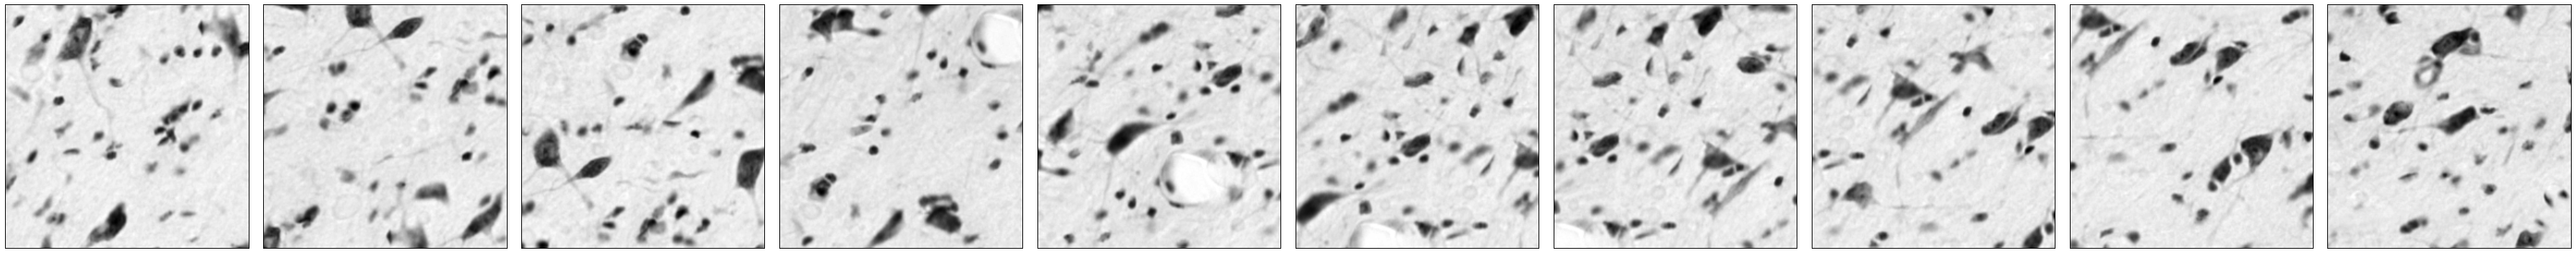

In [43]:
display_images_in_grids(patches_with_desired_label[100:110], nc=10, cmap=plt.cm.gray)

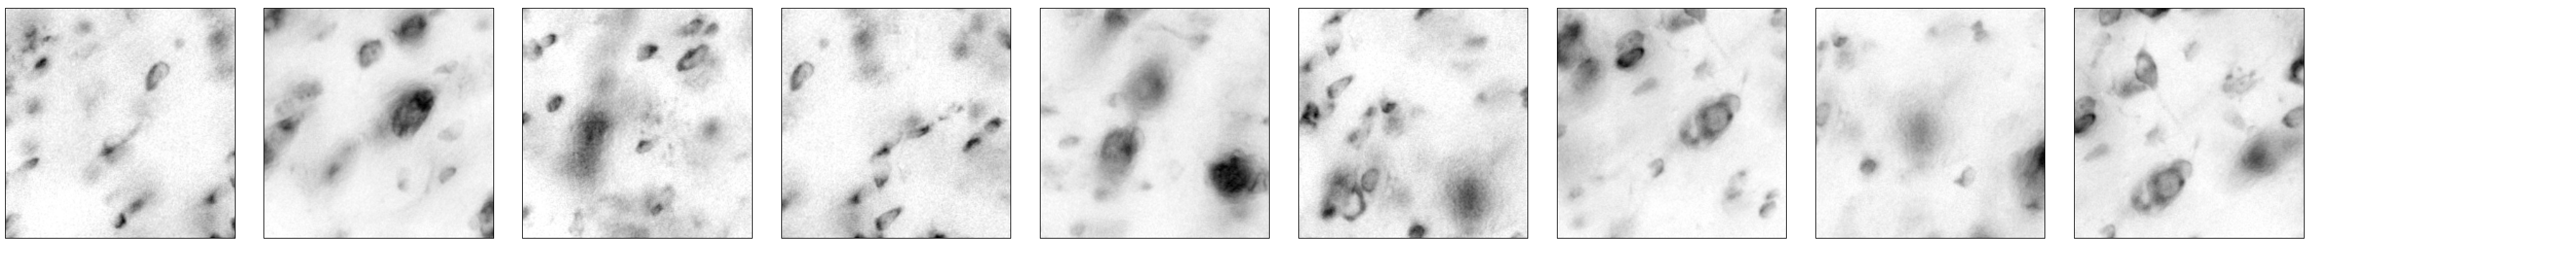

In [44]:
e1 = len(positive_addresses_traindata) + len(negative_addresses_traindata)
e2 = len(positive_addresses_traindata) + len(negative_addresses_traindata) + len(positive_addresses_testdata) 
display_images_in_grids(patches_with_desired_label[e1+10:e1+100:10], nc=10, cmap=plt.cm.gray)

In [45]:
def compute_classification_metrics(probs, labels):
    """
    Args:
        probs ((n,)-array of prediction value between 0 and 1): prediction.
        labels ((n,)-array of 0/1 or -1/1): ground-truth labels.
        
    Returns:
    """

    precision_allthresh = {}
    recall_allthresh = {}
    f1score_allthresh = {}
    tp_normalized_allthresh = {}
    fp_normalized_allthresh = {}
    acc_allthresh = {}
    
    n_pos = np.count_nonzero(labels == 1)
    n_neg = np.count_nonzero(labels != 1)
    n = len(labels)
    
    for th in np.arange(0., 1., 0.01):

        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in labels], soft=False,
                                     normalize=False, binary=True, decision_thresh=th)
        tp = cm[0,0]
        fn = cm[0,1]
        fp = cm[1,0]
        tn = cm[1,1]
        
        acc = (tp + tn) / float(n)

        tp_normalized = tp / n_pos
#                 fn_normalized = fn / n_pos
        fp_normalized = fp / n_neg
#                 tn_normalized = tn / n_neg

        precision = float(tp) / (tp + fp)
        recall = float(tp) / (tp + fn)
        f1score = 2*recall*precision/(recall+precision)

        tp_normalized_allthresh[float(th)] = tp_normalized
        fp_normalized_allthresh[float(th)] = fp_normalized
        precision_allthresh[float(th)] = precision
        recall_allthresh[float(th)] = recall
        f1score_allthresh[float(th)] = f1score
        acc_allthresh[float(th)] = acc
        
    optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f1score_allthresh[th] for th in np.arange(0, 1, 0.01)])]            
    fopt = f1score_allthresh[optimal_th]

    return {'acc': acc_allthresh,
        'tp': tp_normalized_allthresh,
#             fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized_allthresh
    'fp': fp_normalized_allthresh,
#             tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized_allthresh
    'precision': precision_allthresh,
    'recall': recall_allthresh,
    'f1score': f1score_allthresh,
           'opt_thresh': optimal_th,
           'fopt': fopt}

In [52]:
training_accuracies = defaultdict(list)
test_accuracies = defaultdict(list)
training_f1s = defaultdict(list)
test_f1s = defaultdict(list)

for trial in range(10):

    # If train and test data are from different sets
    n_train_pos = 1000
    training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)
    n_test_pos = 2000
    test_pos_indices = np.random.choice(range(len(positive_addresses_testdata)),
                                        size=n_test_pos, 
                                        replace=False)
    
    # If train and test are from same set
#     n_pos_total = len(positive_addresses)
#     n_train_pos = 1000
#     training_pos_indices = np.random.choice(range(n_pos_total), n_train_pos, replace=False)
#     test_pos_indices = np.random.choice(np.setdiff1d(range(n_pos_total), training_pos_indices),
#                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
#     n_test_pos = len(test_pos_indices)
    
    ###############

    # If train and test data are from different sets
    n_train_neg = 1000
    training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)
    n_test_neg = 2000
    test_neg_indices = np.random.choice(range(len(negative_addresses_testdata)),
                                        size=n_test_neg, 
                                        replace=False)

    # If train and test are from same set
#     n_neg_total = len(negative_addresses)
#     n_train_neg = 1000
#     training_neg_indices = np.random.choice(range(n_neg_total), n_train_neg, replace=False)
#     test_neg_indices = np.random.choice(np.setdiff1d(range(n_neg_total), training_neg_indices), 
#                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
#     n_test_neg = len(test_neg_indices)
    
    print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
    print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

    ################

    # If train and test data are from different sets
    addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
    addresses_test_pos = [positive_addresses_testdata[i] for i in test_pos_indices]
    addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]
    addresses_test_neg = [negative_addresses_testdata[i] for i in test_neg_indices]

    # If train and test data are from same set
#     addresses_train_pos = [positive_addresses[i] for i in training_pos_indices]
#     addresses_test_pos = [positive_addresses[i] for i in test_pos_indices]
#     addresses_train_neg = [negative_addresses[i] for i in training_neg_indices]
#     addresses_test_neg = [negative_addresses[i] for i in test_neg_indices]

    #################
    
    scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
    features_train_pos = {(scheme, 'transform%d'%tf_variant): 
                          [features_dict[(scheme, 'transform%d'%tf_variant)][addr] 
                           for addr in addresses_train_pos]
#                               for tf_variant in range(8)}
                          for tf_variant in range(1)}
    features_train_neg = {(scheme, 'transform%d'%tf_variant): 
                          [features_dict[(scheme, 'transform%d'%tf_variant)][addr] 
                           for addr in addresses_train_neg]
#                               for tf_variant in range(8)}
                          for tf_variant in range(1)}
    
    scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
    features_test_pos = {(scheme, 'transform%d'%tf_variant): 
                         [features_dict[(scheme, 'transform%d'%tf_variant)][addr] 
                          for addr in addresses_test_pos]
#                              for tf_variant in range(8)}
                         for tf_variant in range(1)}
    features_test_neg = {(scheme, 'transform%d'%tf_variant): 
                         [features_dict[(scheme, 'transform%d'%tf_variant)][addr]
                          for addr in addresses_test_neg]
#                              for tf_variant in range(8)}
                         for tf_variant in range(1)}

    #################

#         for augment_training in [True, False]:
    for augment_training in [False]:
        
        scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'

        feature_classifier_alg = 'lr'
#             feature_classifier_alg = 'xgb2'
#             feature_classifier_alg = 'lin_svc'
#             feature_classifier_alg = 'lin_svc_calib'
        sample_weights = None   

        if augment_training:
            train_data_list = []
            train_label_list = []
            for tf in range(8):
                train_data = np.r_[features_train_pos[(scheme,'transform%d'%tf)], 
                                   features_train_neg[(scheme,'transform%d'%tf)]]
                train_data_list.append(train_data)

                train_labels = np.r_[np.ones((len(features_train_pos[(scheme,'transform%d'%tf)]), )), 
                                     -np.ones((len(features_train_neg[(scheme,'transform%d'%tf)]), ))]
                train_label_list.append(train_labels)

            train_data = np.concatenate(train_data_list)
            train_labels = np.concatenate(train_label_list)        
        else:
            train_data = np.r_[features_train_pos[(scheme,'transform0')], 
                               features_train_neg[(scheme,'transform0')]]
            train_labels = np.r_[np.ones((len(features_train_pos[(scheme,'transform0')]), )), 
                                 -np.ones((len(features_train_neg[(scheme,'transform0')]), ))]


        clf = train_binary_classifier(train_data, train_labels,
                               alg=feature_classifier_alg, 
                               sample_weights=sample_weights)

        #     trained_classifiers[structure] = clf

        #         clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
        #         create_parent_dir_if_not_exists(clf_fp)
        #         joblib.dump(clf, clf_fp)
        #         upload_to_s3(clf_fp)


        train_metrics = compute_classification_metrics(clf.predict_proba(train_data)[:,1], train_labels)
        train_optthresh = train_metrics['opt_thresh']
        train_acc = train_metrics['acc'][train_optthresh]
#             train_acc = accuracy_score(train_labels, clf.predict(train_data), normalize=True)
        print "Training accuracy = %.3f, optimal threshold = %.3f" % (train_acc, train_optthresh)
        training_accuracies[(scheme, 'augment' if augment_training else 'no-augment')].append(train_acc)
        training_f1s[(scheme, 'augment' if augment_training else 'no-augment')].append(train_metrics['fopt'])

        scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
        test_data = np.r_[features_test_pos[(scheme,'transform0')], features_test_neg[(scheme,'transform0')]]
        test_labels = np.r_[np.ones((len(features_test_pos[(scheme,'transform0')]), )), 
                             -np.ones((len(features_test_neg[(scheme,'transform0')]), ))]
        test_metrics = compute_classification_metrics(clf.predict_proba(test_data)[:,1], test_labels)
        test_acc = test_metrics['acc'][train_optthresh]
#             test_acc = accuracy_score(test_labels, clf.predict(test_data), normalize=True)
        print "Test accuracy = %.3f" % test_acc
        test_accuracies[(scheme, 'augment' if augment_training else 'no-augment')].append(test_acc)
        test_f1s[(scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics['fopt'])

Training: 1000 positive, 1000 negative
Test: 2000 positive, 2000 negative


Fitting classifier: 0.76 seconds


Training accuracy = 0.865, optimal threshold = 0.410
Test accuracy = 0.607
Training: 1000 positive, 1000 negative
Test: 2000 positive, 2000 negative


Fitting classifier: 0.87 seconds


Training accuracy = 0.870, optimal threshold = 0.440
Test accuracy = 0.548
Training: 1000 positive, 1000 negative
Test: 2000 positive, 2000 negative


Fitting classifier: 0.54 seconds


Training accuracy = 0.864, optimal threshold = 0.420
Test accuracy = 0.595
Training: 1000 positive, 1000 negative
Test: 2000 positive, 2000 negative


Fitting classifier: 0.90 seconds


Training accuracy = 0.859, optimal threshold = 0.430
Test accuracy = 0.617
Training: 1000 positive, 1000 negative
Test: 2000 positive, 2000 negative


Fitting classifier: 0.82 seconds


Training accuracy = 0.869, optimal threshold = 0.460
Test accuracy = 0.586
Training: 1000 positive, 1000 negative
Test: 2000 positive, 2000 negative


Fitting classifier: 0.77 seconds


Training accuracy = 0.874, optimal threshold = 0.460
Test accuracy = 0.642
Training: 1000 positive, 1000 negative
Test: 2000 positive, 2000 negative


Fitting classifier: 0.54 seconds


Training accuracy = 0.860, optimal threshold = 0.420
Test accuracy = 0.551
Training: 1000 positive, 1000 negative
Test: 2000 positive, 2000 negative


Fitting classifier: 0.69 seconds


Training accuracy = 0.886, optimal threshold = 0.510
Test accuracy = 0.626
Training: 1000 positive, 1000 negative
Test: 2000 positive, 2000 negative


Fitting classifier: 0.79 seconds


Training accuracy = 0.869, optimal threshold = 0.450
Test accuracy = 0.605
Training: 1000 positive, 1000 negative
Test: 2000 positive, 2000 negative


Fitting classifier: 0.71 seconds


Training accuracy = 0.865, optimal threshold = 0.470
Test accuracy = 0.595


In [ ]:
training_accuracies = defaultdict(list)
test_accuracies = defaultdict(list)
training_f1s = defaultdict(list)
test_f1s = defaultdict(list)

for trial in range(10):

    # If train and test data are from different sets
    n_train_pos = 1000
    training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)
    n_test_pos = 2000
    test_pos_indices = np.random.choice(range(len(positive_addresses_testdata)),
                                        size=n_test_pos, 
                                        replace=False)
    
    # If train and test are from same set
#     n_pos_total = len(positive_addresses)
#     n_train_pos = 1000
#     training_pos_indices = np.random.choice(range(n_pos_total), n_train_pos, replace=False)
#     test_pos_indices = np.random.choice(np.setdiff1d(range(n_pos_total), training_pos_indices),
#                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
#     n_test_pos = len(test_pos_indices)
    
    ###############

    # If train and test data are from different sets
    n_train_neg = 1000
    training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)
    n_test_neg = 2000
    test_neg_indices = np.random.choice(range(len(negative_addresses_testdata)),
                                        size=n_test_neg, 
                                        replace=False)

    # If train and test are from same set
#     n_neg_total = len(negative_addresses)
#     n_train_neg = 1000
#     training_neg_indices = np.random.choice(range(n_neg_total), n_train_neg, replace=False)
#     test_neg_indices = np.random.choice(np.setdiff1d(range(n_neg_total), training_neg_indices), 
#                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
#     n_test_neg = len(test_neg_indices)
    
    print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
    print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

    ################

    # If train and test data are from different sets
    addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
    addresses_test_pos = [positive_addresses_testdata[i] for i in test_pos_indices]
    addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]
    addresses_test_neg = [negative_addresses_testdata[i] for i in test_neg_indices]

    # If train and test data are from same set
#     addresses_train_pos = [positive_addresses[i] for i in training_pos_indices]
#     addresses_test_pos = [positive_addresses[i] for i in test_pos_indices]
#     addresses_train_neg = [negative_addresses[i] for i in training_neg_indices]
#     addresses_test_neg = [negative_addresses[i] for i in test_neg_indices]

    #################
    
    for scheme in schemes:
        
        features_train_pos = {(scheme, 'transform%d'%tf_variant): 
                              [features_dict[(scheme, 'transform%d'%tf_variant)][addr] 
                               for addr in addresses_train_pos]
#                               for tf_variant in range(8)}
                              for tf_variant in range(1)}
        features_train_neg = {(scheme, 'transform%d'%tf_variant): 
                              [features_dict[(scheme, 'transform%d'%tf_variant)][addr] 
                               for addr in addresses_train_neg]
#                               for tf_variant in range(8)}
                              for tf_variant in range(1)}
        features_test_pos = {(scheme, 'transform%d'%tf_variant): 
                             [features_dict[(scheme, 'transform%d'%tf_variant)][addr] 
                              for addr in addresses_test_pos]
#                              for tf_variant in range(8)}
                             for tf_variant in range(1)}
        features_test_neg = {(scheme, 'transform%d'%tf_variant): 
                             [features_dict[(scheme, 'transform%d'%tf_variant)][addr]
                              for addr in addresses_test_neg]
#                              for tf_variant in range(8)}
                             for tf_variant in range(1)}

        #################

#         for augment_training in [True, False]:
        for augment_training in [False]:

            feature_classifier_alg = 'lr'
#             feature_classifier_alg = 'xgb2'
#             feature_classifier_alg = 'lin_svc'
#             feature_classifier_alg = 'lin_svc_calib'
            sample_weights = None   

            if augment_training:
                train_data_list = []
                train_label_list = []
                for tf in range(8):
                    train_data = np.r_[features_train_pos[(scheme,'transform%d'%tf)], 
                                       features_train_neg[(scheme,'transform%d'%tf)]]
                    train_data_list.append(train_data)

                    train_labels = np.r_[np.ones((len(features_train_pos[(scheme,'transform%d'%tf)]), )), 
                                         -np.ones((len(features_train_neg[(scheme,'transform%d'%tf)]), ))]
                    train_label_list.append(train_labels)

                train_data = np.concatenate(train_data_list)
                train_labels = np.concatenate(train_label_list)        
            else:

                train_data = np.r_[features_train_pos[(scheme,'transform0')], 
                                   features_train_neg[(scheme,'transform0')]]
                train_labels = np.r_[np.ones((len(features_train_pos[(scheme,'transform0')]), )), 
                                     -np.ones((len(features_train_neg[(scheme,'transform0')]), ))]


            clf = train_binary_classifier(train_data, train_labels,
                                   alg=feature_classifier_alg, 
                                   sample_weights=sample_weights)

            #     trained_classifiers[structure] = clf

            #         clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
            #         create_parent_dir_if_not_exists(clf_fp)
            #         joblib.dump(clf, clf_fp)
            #         upload_to_s3(clf_fp)


            train_metrics = compute_classification_metrics(clf.predict_proba(train_data)[:,1], train_labels)
            train_optthresh = train_metrics['opt_thresh']
            train_acc = train_metrics['acc'][train_optthresh]
#             train_acc = accuracy_score(train_labels, clf.predict(train_data), normalize=True)
            print "Training accuracy = %.3f, optimal threshold = %.3f" % (train_acc, train_optthresh)
            training_accuracies[(scheme, 'augment' if augment_training else 'no-augment')].append(train_acc)
            training_f1s[(scheme, 'augment' if augment_training else 'no-augment')].append(train_metrics['fopt'])
        
            test_data = np.r_[features_test_pos[(scheme,'transform0')], features_test_neg[(scheme,'transform0')]]
            test_labels = np.r_[np.ones((len(features_test_pos[(scheme,'transform0')]), )), 
                                 -np.ones((len(features_test_neg[(scheme,'transform0')]), ))]
            test_metrics = compute_classification_metrics(clf.predict_proba(test_data)[:,1], test_labels)
            test_acc = test_metrics['acc'][train_optthresh]
#             test_acc = accuracy_score(test_labels, clf.predict(test_data), normalize=True)
            print "Test accuracy = %.3f" % test_acc
            test_accuracies[(scheme, 'augment' if augment_training else 'no-augment')].append(test_acc)
            test_f1s[(scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics['fopt'])

Mean test acc:
{('normalize_mu_region_sigma_wholeImage_(-1,9)', 'no-augment'): 0.6682137926827485}


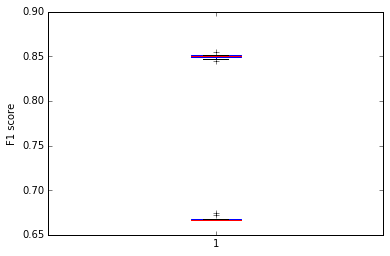

In [50]:
# plt.boxplot(training_accuracies.values(), labels=training_accuracies.keys());
# plt.boxplot(test_accuracies.values(), labels=training_accuracies.keys());
plt.boxplot(training_f1s.values());
plt.boxplot(test_f1s.values());
plt.ylabel('F1 score');
# plt.ylim([0.75, 1.]);

print 'Mean test acc:'
print {k: np.mean(v) for k, v in test_f1s.iteritems()}

Mean test acc:
{('normalize_mu_region_sigma_wholeImage_(-1,9)', 'no-augment'): 0.54879999999999995}


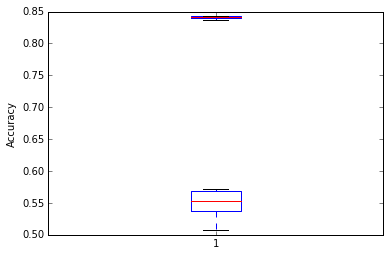

In [51]:
# plt.boxplot(training_accuracies.values(), labels=training_accuracies.keys());
# plt.boxplot(test_accuracies.values(), labels=training_accuracies.keys());
plt.boxplot(training_accuracies.values());
plt.boxplot(test_accuracies.values());
plt.ylabel('Accuracy');
# plt.ylim([0.75, 1.]);

print 'Mean test acc:'
print {k: np.mean(v) for k, v in test_accuracies.iteritems()}

In [106]:
training_accuracies.keys()

[('stretch_min_max', 'no-augment')]

In [39]:
negative_composition_rules = ['surround500']

In [40]:
fixed_n_pos = 500
fixed_n_neg = 500

In [239]:
acc_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
# fn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
# tn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
precision_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
recall_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
f1score_normalized_all_clfs_all_structures_all_negcomprule =  defaultdict(lambda: defaultdict(dict))

classifier_ids = [0]

for classifier_id in classifier_ids:
    
    clf_allClasses = trained_classifiers

    ####################################################
    # Compute accuracy against each structure surround #
    ####################################################
    
    for neg_composition_rule in negative_composition_rules:
            
        ncols = 5
        nrows = int(np.ceil(len(structures_found)/float(ncols)))

    #     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
    #     axes = axes.flatten()

        for i, structure in enumerate(structures_found):

#             features_pos = test_features[structure]
            features_pos = features_pos_unused
    
            if fixed_n_pos is not None:
                features_pos = features_pos[np.random.choice(range( len(features_pos)), replace=False, size=(min(fixed_n_pos, len(features_pos)),))]

            n_pos = len(features_pos)
            print structure, n_pos, 'positive'

            if neg_composition_rule.startswith('surround'):
                if neg_composition_rule == 'surround200':
                    margin_um = 200
                elif neg_composition_rule == 'surround500':
                    margin_um = 500
                elif neg_composition_rule == 'surround1000':
                    margin_um = 1000
                else:
                    margin_um = None
                neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')] + \
                [convert_to_surround_name(structure, margin=margin_um, suffix=surr_l) for surr_l in structures_found]
            elif neg_composition_rule == 'negative':
                neg_classes = [structure + '_negative']
            else:
                raise
            
            neg_classes = list(set(neg_classes) & set(labels_found))

#             features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
            features_neg = features_neg_unused
    
            if fixed_n_neg is not None:
                features_neg = features_neg[np.random.choice(range( len(features_neg)), replace=False, size=(min(fixed_n_neg, len(features_neg)),))]        

            n_neg = len(features_neg)
            print structure, n_neg, 'negative'

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            if structure not in clf_allClasses:
                sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
                continue

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            
            
            ######### SOFT ########
#             cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
#                                              normalize=False)
#             tp = cm[0,0]
#             fn = cm[0,1]
#             fp = cm[1,0]
#             tn = cm[1,1]

#             acc = (tp + tn) / (n_pos + n_neg)
#             acc_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = acc

            ######## PRECISION-RECALL ########
            precision_allthresh = {}
            recall_allthresh = {}
            f1score_allthresh = {}
            tp_normalized_allthresh = {}
            fp_normalized_allthresh = {}
            for th in np.arange(0., 1., 0.01):
            
                cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=False,
                                             normalize=False, binary=True, decision_thresh=th)

                tp = cm[0,0]
                fn = cm[0,1]
                fp = cm[1,0]
                tn = cm[1,1]
                
                tp_normalized = tp / n_pos
#                 fn_normalized = fn / n_pos
                fp_normalized = fp / n_neg
#                 tn_normalized = tn / n_neg

                precision = float(tp) / (tp + fp)
                recall = float(tp) / (tp + fn)
                f1score = 2*recall*precision/(recall+precision)
                
                tp_normalized_allthresh[float(th)] = tp_normalized
                fp_normalized_allthresh[float(th)] = fp_normalized
                precision_allthresh[float(th)] = precision
                recall_allthresh[float(th)] = recall
                f1score_allthresh[float(th)] = f1score

            tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tp_normalized_allthresh
#             fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized_allthresh
            fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fp_normalized_allthresh
#             tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized_allthresh
            precision_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = precision_allthresh
            recall_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = recall_allthresh
            f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = f1score_allthresh
    #     plt.tight_layout()

        ############################

#         xticks = range(1, 1 + len(structures_sorted_by_size))

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [acc_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size]);
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylim([0.6, 1]);
#         plt.ylabel('Accuracy');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.show();

#         print 'test accuracy:', np.mean(acc_all_clfs_all_structures[classifier_id].values())

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [tp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tp', markerfmt='bo');
#         plt.stem(xticks, [fn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fn', markerfmt='ro');
#         plt.stem(xticks, [fp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fp', markerfmt='ko');
#         plt.stem(xticks, [tn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tn', markerfmt='go');
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylabel('Percentage');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.legend();
#         plt.show();

tp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
# fn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
# tn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
precision_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
recall_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
f1score_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None

SNR 500 positive
SNR 500 negative


In [240]:
structures_sorted_by_size = ['SNR']

In [241]:
fopt_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
optthresh_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))

for classifier_id in classifier_ids:

    for neg_composition_rule in negative_composition_rules:

        for s in structures_sorted_by_size:
            fp_allthresh = fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            tp_allthresh = tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            f_allthresh = f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]

            optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f_allthresh[th] for th in np.arange(0, 1, 0.01)])]
            optthresh_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] = optimal_th
            fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] = f_allthresh[optimal_th]

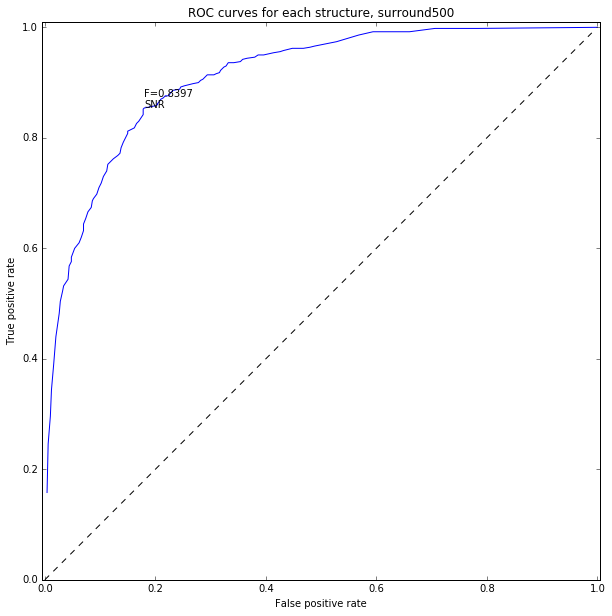

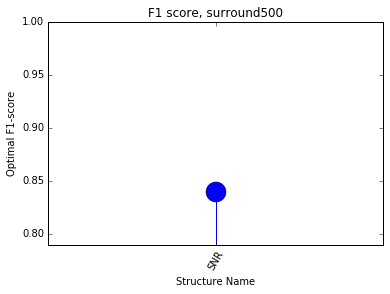

In [242]:
for classifier_id in classifier_ids:
    for neg_composition_rule in negative_composition_rules:

    #     plt.figure(figsize=(15, 10));
        plt.figure(figsize=(10, 10));
        plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='k', linestyle='--');

        fopt = {}
        for s in structures_sorted_by_size:
            fp_allthresh = fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            tp_allthresh = tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            f_allthresh = f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]

            plt.plot([fp_allthresh[float(th)] for th in np.arange(0, 1, 0.01)],
                 [tp_allthresh[float(th)] for th in np.arange(0, 1, 0.01)]);

            optimal_th = optthresh_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            fopt = f_allthresh[optimal_th]

    #         plt.scatter(fp_allthresh[optimal_th], tp_allthresh[optimal_th], 
    #             marker='o', facecolors='none', edgecolors='k')
            plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th]+.02, 'F=%.4f' % (fopt))
            plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], s, fontsize=10)

    #     plt.legend();
        plt.ylabel('True positive rate');
        plt.xlabel('False positive rate');
    #     plt.xticks(np.arange(0,1,.1));
        plt.axis('equal');
        plt.ylim([0,1.01]);
        plt.xlim([0,1]);
        plt.title('ROC curves for each structure, %s' % (neg_composition_rule));
        plt.show();

    #     plt.figure();
    #     plt.hist(fopt.values(), bins=np.arange(0.7, 1.0, 0.01));
    #     plt.ylabel("Number of structures");
    #     plt.xlabel("Optimal f1 score");
    #     plt.show();

        plt.figure();
        xticks = range(1, 1 + len(structures_sorted_by_size))
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                                                       [fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size],
         markerfmt='o', markevery=[4,8]);
        plt.setp(markerLines, markersize=20, alpha=1.)
        plt.xticks(xticks, structures_sorted_by_size, rotation='60');
        plt.ylabel('Optimal F1-score');
        plt.xlabel('Structure Name');
        plt.ylim(np.min([fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size])-.05, 1);
        plt.title('F1 score, %s' % (neg_composition_rule));
        plt.legend();
        plt.show();